# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center> Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План:**
 - Часть 1. Построение признаков и визуальный анализ данных
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 

   
**Также  будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *conda install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#conda install seaborn
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Создаем на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создаем следующие 13 признаков:**
- time_diff1, ..., time_diff9 – промежутки между посещением 1 и 2 сайта, ..., 9 и 10 сайта в сессии (в секундах). Посещения сайтов не сторого упорядочены по времени, поэтому эти величины где-то могут быть отрицательными. Если сайтов в сессии меньше 10, разницы можно сделать нулевыми
- session_timespan – продолжительность сессии. Из-за того, что посещения сайтов не сторого упорядочены по времени, продолжительностью сессии будем считать разницу между максимальным и минимальным временем посещения сайтов в сессии (в секундах).
- #unique_sites – число уникальных сайтов в сессии 
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 13 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (это видно и чуть ниже по тому, как функция вызывается).

In [2]:
def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' input 
    csv_files_mask = dir of session files,
    site_freq_path = dir of dictionary,
    feature_names  = names of the features
    session_length = N size of the session ,
    window_size    = M size of the window
    output 
    dataFrame where  site1,...site(N) are the site in the session 
            time_diff1,... time_diff(N-1) are the difference between the open time of each site in the session
            unique_site is the number of the unique site in the session
            start_hour is the hour of the start the session
            day_of_week is the day of the start the session
            target is the user_id
    '''
    print ('prepare_train_set_with_feature engineering')
    
    #from glob import glob 
    
    data = pd.DataFrame(columns = feature_names, dtype=np.int64)
    
    with open(site_freq_path ) as dic_pkl:
        dic =pickle.load(dic_pkl)    # dictionary where keys are site names values are (site_id, frequency of site_id)
    #print (len(dic))
    
    # from csv_files_mask to read all files
    for f in glob(csv_files_mask):
        df = pd.read_csv( f, header=None, names=['id', 'timestamp', 'site']) # make the dataframe from file
        #print (len(df))
        N_rows = int(np.ceil(len(df)/float(window_size)))
        # array with site_id  from dataframe now it is initialed  zeros length is multiple to the session_length
        #print (N_rows)
        
        #ar = np.zeros(len(df), dtype=np.int64)
        ar = map( lambda x: dic[x][0], df.site.values)
        
        ar_time = pd.to_datetime(df['timestamp']).values
        
        #for i,x in enumerate (df.site):
            #ar[i] = dic[x][0]
        #print (ar.shape)
        N_unique_site = np.zeros(N_rows, dtype = np.int64)
        ar2 = np.array([], dtype = np.int64)
        ar2_time = np.array([] ,dtype='datetime64')
        
        for i in range (N_rows+1):
            # sites in the session length with window size
            sites_setion = ar[i*window_size : i*window_size + session_length ]
            ar2 = np.append(ar2, sites_setion)
            # запишем время посешения сайта  в матрицу по сессиям длины session_length и с окном длины window_size
            ar2_time = np.append(ar2_time, ar_time[i*window_size : i*window_size + session_length ])
            
            if i == N_rows: break 
            N_unique_site[i] = len(np.unique(sites_setion)) # колличество уникальных сайтов в сессии 
            #print (N_unique_site[i])
        
        ar2 = np.append(ar2,np.tile([0], (N_rows*session_length - len(ar2)))) # добавим в пустые згачения 0
        # добавим в пустые значения последнее время
        ar2_time = np.append(ar2_time ,np.tile(ar_time[-1], (N_rows*session_length - len(ar2_time)))) 
        
        # convert array to matrixs
        ar2 = ar2.reshape((N_rows, session_length)) # convert array to matrix
        ar2_time = ar2_time.reshape((N_rows, session_length)) # convert array to matrix
        N_unique_site = N_unique_site.reshape((N_rows, 1))# convert array to matrix
        #print (N_unique_site.shape, ar2.shape, ar2_time.shape)
        
        # время между посещениями сайтов в одной сессии в секундах
        time_diff = np.diff(ar2_time, axis =1)/np.timedelta64(1, 's')
        
        # продолжительность сессии в сек
        session_timespan = (np.max(ar2_time, axis =1)-np.min(ar2_time, axis =1))/np.timedelta64(1, 's') 
        session_timespan = session_timespan.reshape((N_rows, 1)).astype(int) # convert array to matrix
        
        # час начала сессии
        start_hour = (pd.to_datetime(np.min(ar2_time, axis =1))).hour
        #print (start_hour)
        start_hour = start_hour.reshape((N_rows, 1)) # convert array to matrix
        
        # день недели начала сессии    
        day_of_week = (pd.to_datetime(np.min(ar2_time, axis =1))).dayofweek
        day_of_week = day_of_week.reshape((N_rows, 1)) # convert array to matrix
        
        
        #print (time_diff.shape, session_timespan.shape, start_hour.shape, day_of_week.shape)
        
        matrix = (np.hstack((ar2, time_diff, session_timespan, N_unique_site, start_hour, day_of_week))).astype(np.int64)
        
        data_ = pd.DataFrame(matrix, columns = feature_names[:-1], dtype = np.int64)
        # target
        data_[feature_names[-1]] = df['id']
        data_ = data_.astype(np.int64)
        data = data.append(data_)
        #print (data.head())
        
    return data.astype(np.int64)
    

**Проверим функцию на игрушечном примере.**

In [3]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe('capstone_websites_data/3users_toy/*', 
                                   site_freq_path='capstone_websites_data/site_freq_3users.pkl',
                                   feature_names=feature_names, session_length=10)

prepare_train_set_with_feature engineering


In [4]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
0,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
0,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
1,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Применим функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите session_length=10.**

In [7]:
train_data_10users = prepare_train_set_with_fe('capstone_websites_data/10users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_10users.pkl',
                                   feature_names=feature_names, session_length=10)

prepare_train_set_with_feature engineering


In [8]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,4,5,6,7,8,7,273,3,28,916,-1523,10,0,0,1,1523,8,8,4,31
1,7,8,7,7,9,10,11,12,13,14,1,0,1,0,0,1,0,163,105,271,8,8,4,31
2,7,15,16,17,17,8,17,17,10,3,4,3,8,1,0,14,1,242,0,273,7,8,4,31
3,18,19,20,17,21,17,17,17,17,22,1,0,0,2,1,1,25,1,0,31,6,8,4,31
4,23,24,25,17,26,27,28,29,30,31,0,0,1,1,1,1,0,1,1,6,10,8,4,31


**Применим функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите session_length=10.**

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe('capstone_websites_data/150users/*', 
                                                site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                                feature_names=feature_names, session_length=10)

prepare_train_set_with_feature engineering
Wall time: 24.5 s


**Сохраним в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_feature_names = ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']

In [11]:
new_features_10users = train_data_10users[ new_feature_names]
new_features_150users = train_data_150users[ new_feature_names]

In [12]:
with open('new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open('new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

In [13]:
train_data_10users.to_csv('capstone_websites_data/new_train_data_10users.csv',
                          index_label='session_id', float_format='%d')

In [14]:
train_data_150users.to_csv('capstone_websites_data/new_train_data_150users.csv',
                          index_label='session_id', float_format='%d')

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [17]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,4,5,6,7,8,7,273,3,28,916,-1523,10,0,0,1,1523,8,8,4,John
1,7,8,7,7,9,10,11,12,13,14,1,0,1,0,0,1,0,163,105,271,8,8,4,John
2,7,15,16,17,17,8,17,17,10,3,4,3,8,1,0,14,1,242,0,273,7,8,4,John
3,18,19,20,17,21,17,17,17,17,22,1,0,0,2,1,1,25,1,0,31,6,8,4,John
4,23,24,25,17,26,27,28,29,30,31,0,0,1,1,1,1,0,1,1,6,10,8,4,John


**1. Построем гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

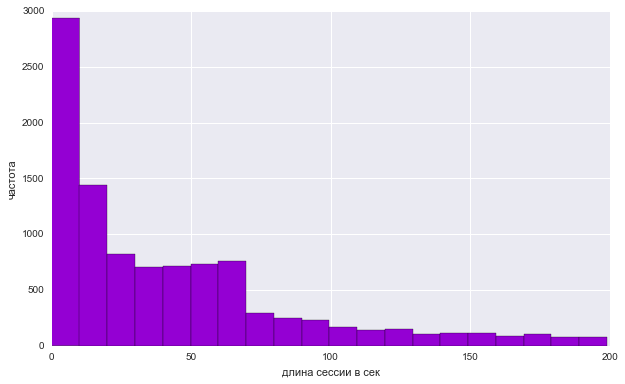

In [18]:
train_data_10users['session_timespan'][train_data_10users['session_timespan']<200].\
                    hist(bins = 20, figsize = (10,6),color ='darkviolet')#, xlabel = u'длина сессии')
plt.xlabel(u'длина сессии в сек')
plt.ylabel(u'частота')

**2. Построем гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

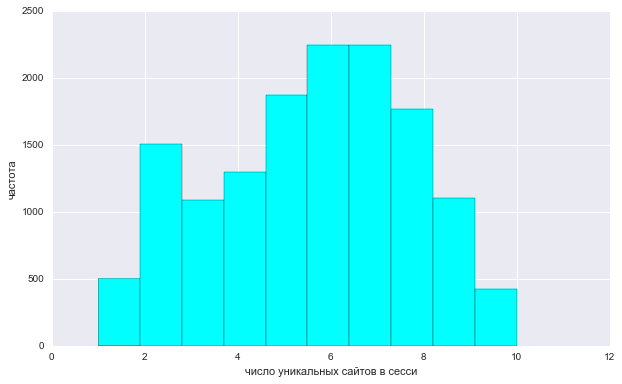

In [19]:
train_data_10users['#unique_sites'].hist(bins = 10, figsize = (10,6),color ='aqua')
plt.xlabel(u'число уникальных сайтов в сесси')
plt.ylabel(u'частота') 

**3. Построем гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишим оси в каждой из 10 гистограмм.**

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    
    axes[idx].hist(sub_df['#unique_sites'],bins =10, color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'число уникальных сайтов')
    axes[idx].axis([0, 10, 0, 900])
    axes[idx].set_ylabel(u'частота сайтов')
    axes[idx].legend()
    

**6. Построем гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*.**

In [23]:
train_data_10users['day_of_week'].hist( bins = 7, figsize = (10,6), color = 'sienna')

**4. Построем гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*.**

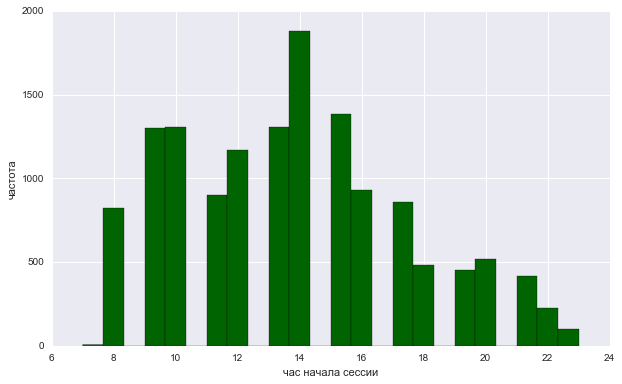

In [21]:
train_data_10users['start_hour'].hist( bins = 24, figsize = (10,6),color ='darkgreen')
plt.xlabel(u'час начала сессии')
plt.ylabel(u'частота') 

**5. Постройем гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя  гистограмму его/ее цветом (*color_dic*). Подпишим оси **

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    
    axes[idx].hist(sub_df['start_hour'],bins =24, color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'час начала сессии')
    axes[idx].axis([0, 24, 0, 500])
    axes[idx].set_ylabel(u'частота')
    axes[idx].legend()
     

**7. Построем гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой.  Метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометем легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя гистограмму в его/ее цвет (*color_dic*). **

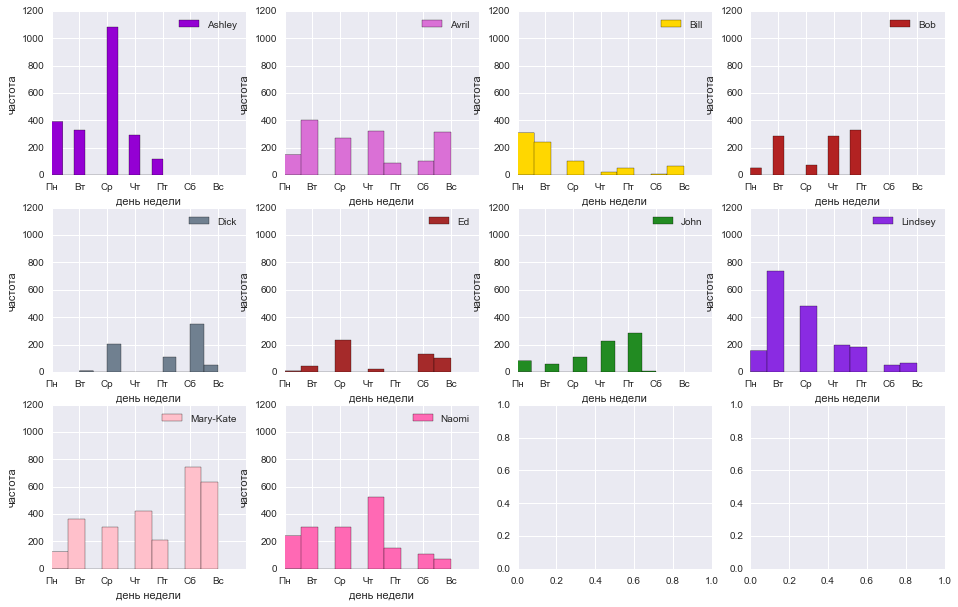

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
      
    axes[idx].hist(sub_df['day_of_week'], color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'день недели')
    axes[idx].axis([0, 7, 0, 1200])
    axes[idx].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    axes[idx].set_ylabel(u'частота')
    axes[idx].legend()

**Загрузим сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [8]:
with open('capstone_websites_data/site__freq_10users.pkl' ) as dic_pkl:
    dic_freq_10users =pickle.load(dic_pkl)# dictionary where keys are site names values are (site_id, frequency of site_id) 

**Определим топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [9]:
freq_sorted = sorted([(k,v[0],v[1]) for k,v in dic_freq_10users.items()], key= lambda x: x[2], reverse =True )
top10_freqs = [x[2] for x in freq_sorted[:10]]
top10_sites = [x[0] for x in freq_sorted[:10]]

In [10]:
freq_sorted[:10]

[('s.youtube.com', 209, 8300),
 ('www.google.fr', 51, 7813),
 ('www.google.com', 8, 5441),
 ('mail.google.com', 183, 4158),
 ('www.facebook.com', 3, 4141),
 ('apis.google.com', 129, 3758),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 700, 3244),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 213, 3094),
 ('plus.google.com', 188, 2630),
 ('accounts.google.com', 184, 2089)]

In [28]:
[print (x) for x in zip( top10_sites, top10_freqs)]

('s.youtube.com', 8300)
('www.google.fr', 7813)
('www.google.com', 5441)
('mail.google.com', 4158)
('www.facebook.com', 4141)
('apis.google.com', 3758)
('r3---sn-gxo5uxg-jqbe.googlevideo.com', 3244)
('r1---sn-gxo5uxg-jqbe.googlevideo.com', 3094)
('plus.google.com', 2630)
('accounts.google.com', 2089)


[None, None, None, None, None, None, None, None, None, None]

**9. Нарисуем *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

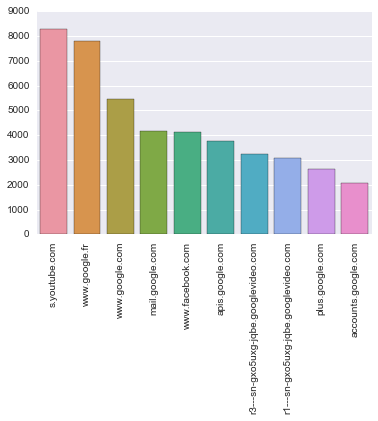

In [29]:
sns.barplot(x = top10_sites, y = top10_freqs)
plt.xticks(rotation=90)

## Часть 3. Дальнейшее построение признаков


будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Функцию для создания новых признаков и применим ее к исходным данным – каталогам с 10 и 150 файлами. Это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуем полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми.**

In [2]:
def feature_engineering(csv_files_mask, site_freq_path, 
                        site_top_list, feature_names, session_length=10, window_size=10):
    ''' input 
    csv_files_mask = dir of session files,
    site_freq_path = dir of dictionary,
    site_top_list = list of top frequincy sites
    feature_names  = names of the features
    session_length = N size of the session ,
    window_size    = M size of the window
    output 
    dataFrame where  t_site1,...t_site(N) are the opens time in hours of the top site at the session 
            time_diff1,... time_diff(N-1) are the difference between the open time of the top site and next
            unique_site is the number of the unique site at the session
            start_hour is the hour of the start the session
            day_of_week is the day of the start the session
            target is the user_id
    '''
    print ('prepare_train_set_with_feature engineering')
    
    #from glob import glob 
    
    data = pd.DataFrame(columns = feature_names, dtype=np.int64)
    
    with open(site_freq_path ) as dic_pkl:
        dic =pickle.load(dic_pkl)    # dictionary where keys are site names values are (site_id, frequency of site_id)
    #print (len(dic))
    
    # from csv_files_mask to read all files
    for f in glob(csv_files_mask):
        df = pd.read_csv( f, header=None, names=['id', 'timestamp', 'site']) # make the dataframe from file of the log
        #print (len(df))
        N_rows = int(np.ceil(len(df)/float(window_size)))
        
        # list of site where site's number in the number from the log
        ar = np.array( map( lambda x: dic[x][0], df['site'].values))
        #list of sites time from the log
        ar_time = pd.to_datetime(df['timestamp'])
        
        site_top_list = np.array(site_top_list)
        # list of (1,0) where 1 is only if element ar in site_top_list
        ind_popular = np.in1d(ar, site_top_list)
        #print (ind_popular[:11])
        
        # list (1,0) where 1 is only if element ar in site_top_list at the session_length with window_size
        ind2           = np.array([], dtype = bool)
        # number of the site_top_list in session
        N_top_site = np.zeros(N_rows, dtype = np.int64)
        # time of the side's open at the session
        ar2_time = np.array([] ,dtype='datetime64')
        
        for i in range (N_rows+1):
            # sites in the session_length with the window_size
            ind_session = ind_popular[i*window_size : i*window_size + session_length ]
            ind2 = np.append(ind2, ind_session)
            # запишем время посешения сайта  в матрицу по сессиям длины session_length и с окном длины window_size
            ar2_time = np.append(ar_time, ar_time[i*window_size : i*window_size + session_length ])
            
            if i == N_rows: break 
            N_top_site[i] = np.sum(ind_session) # колличество top сайтов в сессии 
            #print (N_unique_site[i])
           
        # добавим в пустые значения 0
        ind2 = np.append(ind2, np.tile(False, (N_rows*session_length - len(ind2))))
        # добавим в пустые значения последнее время
        ar2_time = np.append(ar2_time,np.tile(ar2_time[-1], (N_rows*session_length - len(ar2_time))))
        
        # convert array to matrixs
        ind2          = ind2.reshape((N_rows, session_length))          # convert array to matrix
        ar2_time      = ar2_time.reshape((N_rows, session_length))      # convert array to matrix
        
        # time's difference between a site and a next site at the session in second
        diff_time  = np.diff(ar2_time, axis =1)/np.timedelta64(1, 's')
        
        # time of the open of the popular site from site_top_list
        pop_time   =  np.where(ind2, ar2_time, np.datetime64('nat'))
        # difference between the pop site and next in second
        diff_pop_time = np.where(ind2[:,:-1], diff_time, 0)
        
        #print (pop_time.shape, diff_pop_time.shape)
        # количество site_top_list в сессии
        N_top_site = N_top_site.reshape((N_rows, 1))
        
        # минимальное время посещения site_top_list in hours
        min_pop_time = (pd.to_datetime(np.min(pop_time, axis =1))).hour 
        min_pop_time = (np.where(min_pop_time >0, min_pop_time, 0)).reshape((N_rows, 1))
        # максимальное  время посещения site_top_list in hours
        day_pop_time = ((pd.to_datetime(np.max(pop_time, axis =1))).dayofweek)
        day_pop_time = (np.where(day_pop_time >0, day_pop_time, 0)).reshape((N_rows, 1))
        
        # минимальное время между посещениями site_top_list and next в одной сессии в секундах
        mean_pop_diff = np.mean(diff_pop_time, axis =1).reshape((N_rows, 1))
        
        
        
        # максимальное время между посещениями site_top_list and next в одной сессии в секундах
        max_pop_diff = (np.max(diff_pop_time, axis =1)).reshape((N_rows, 1))
        
        #print (N_top_site.shape, min_pop_time.shape, max_pop_time.shape, min_pop_diff.shape, max_pop_diff.shape)
        
        
        matrix = np.hstack((N_top_site, min_pop_time, day_pop_time, mean_pop_diff, max_pop_diff))
        #print ('matrix  ',matrix.shape)
        
                           
        data_ = pd.DataFrame(matrix, columns = feature_names[:-1], dtype = np.int64) 
        # target
        data_[feature_names[-1]] = df['id']
        
        data = data.append(data_)
        #print (data.head())
        
    return data.astype(np.int64)


In [3]:
with open('capstone_websites_data/site_freq_3users.pkl' ) as dic_pkl:
    dic_freq_3users =pickle.load(dic_pkl)    # dictionary where keys are site names values are (site_id, frequency of site_id)

In [4]:
dic_freq_3users.items()

[('mail.google.com', (6, 2)),
 ('meduza.io', (10, 3)),
 ('google.com', (4, 9)),
 ('plus.google.com', (8, 1)),
 ('oracle.com', (2, 8)),
 ('accounts.google.com', (5, 1)),
 ('apis.google.com', (7, 1)),
 ('yandex.ru', (11, 1)),
 ('vk.com', (1, 3)),
 ('football.kulichki.ru', (9, 2)),
 ('geo.mozilla.org', (3, 1))]

In [5]:
top_list = [2, 4]

In [6]:
feature_names = ['Numbe_top_site', 'min_popular_time', 'day_popular_time', 'mean_popular_diff', 'max_popular_diff', 'target']

train_data_toy  = feature_engineering('capstone_websites_data/3users_toy/*',
                                      site_freq_path='capstone_websites_data/site_freq_3users.pkl',
                                      site_top_list =top_list, feature_names = feature_names )#, session_length=10, window_size=10)

prepare_train_set_with_feature engineering


In [7]:
train_data_toy

,Numbe_top_site,min_popular_time,day_popular_time,mean_popular_diff,max_popular_diff,target
0,4,9,4,829,6278,1
1,3,12,4,6,55,1
0,2,9,4,131,1184,2
0,6,9,4,850,6278,3
1,2,12,4,131,1184,3


In [11]:
feature_names = ['N_top_site', 'min_popular_time', 'day_popular_time', 'mean_popular_diff', 'max_popular_diff', 'target']
top30_freqs = [x[2] for x in freq_sorted[:30]]
top30_sites = [x[1] for x in freq_sorted[:30]]

In [12]:
freq_sorted[:30]

[('s.youtube.com', 209, 8300),
 ('www.google.fr', 51, 7813),
 ('www.google.com', 8, 5441),
 ('mail.google.com', 183, 4158),
 ('www.facebook.com', 3, 4141),
 ('apis.google.com', 129, 3758),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 700, 3244),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 213, 3094),
 ('plus.google.com', 188, 2630),
 ('accounts.google.com', 184, 2089),
 ('r2---sn-gxo5uxg-jqbe.googlevideo.com', 699, 1939),
 ('fr-mg42.mail.yahoo.com', 627, 1868),
 ('www.youtube.com', 204, 1804),
 ('r4---sn-gxo5uxg-jqbe.googlevideo.com', 208, 1702),
 ('clients1.google.com', 568, 1493),
 ('download.jboss.org', 1789, 1441),
 ('s-static.ak.facebook.com', 130, 1388),
 ('static.ak.facebook.com', 64, 1265),
 ('i1.ytimg.com', 205, 1232),
 ('twitter.com', 131, 1204),
 ('accounts.youtube.com', 185, 1057),
 ('platform.twitter.com', 68, 1041),
 ('safebrowsing-cache.google.com', 574, 1039),
 ('clients6.google.com', 191, 1039),
 ('translate.google.fr', 1026, 1002),
 ('api.twitter.com', 1599, 982),
 ('accou

In [13]:
new_features_10users  = feature_engineering('capstone_websites_data/10users/*',
                                      site_freq_path='capstone_websites_data/site_freq_10users.pkl',
                                      site_top_list =top30_sites, feature_names = feature_names,
                                           session_length=10, window_size=10)

prepare_train_set_with_feature engineering


In [14]:
new_features_10users.head()

,N_top_site,min_popular_time,day_popular_time,mean_popular_diff,max_popular_diff,target
0,2,8,4,101,916,31
1,1,8,4,0,0,31
2,2,8,4,1,14,31
3,0,0,0,0,0,31
4,0,0,0,0,0,31


In [40]:
with open('capstone_websites_data/site__freq_150users.pkl' ) as dic_pkl:
    dic_freq_150users =pickle.load(dic_pkl)    # dictionary where keys are site names values are (site_id, frequency of site_id)

In [41]:
freq_sorted150 = sorted([(k,v[0],v[1]) for k,v in dic_freq_150users.items()], key= lambda x: x[2], reverse =True )
top30_freqs = [x[2] for x in freq_sorted[:10]]
top30_sites = [x[1] for x in freq_sorted[:10]]
freq_sorted150[:30]

[('www.google.fr', 1, 64785),
 ('www.google.com', 3, 51320),
 ('www.facebook.com', 41, 39002),
 ('apis.google.com', 2, 29983),
 ('s.youtube.com', 178, 29102),
 ('clients1.google.com', 212, 25087),
 ('mail.google.com', 28, 19072),
 ('plus.google.com', 27, 18467),
 ('safebrowsing-cache.google.com', 293, 17960),
 ('www.youtube.com', 105, 16319),
 ('twitter.com', 70, 16219),
 ('platform.twitter.com', 37, 15317),
 ('s-static.ak.facebook.com', 69, 15048),
 ('accounts.google.com', 24, 13855),
 ('www.bing.com', 202, 13797),
 ('static.ak.facebook.com', 40, 13117),
 ('i1.ytimg.com', 107, 13117),
 ('download.jboss.org', 3536, 11740),
 ('api.twitter.com', 3395, 9350),
 ('safebrowsing.clients.google.com', 292, 8981),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 179, 8579),
 ('fr.openclassrooms.com', 1199, 8100),
 ('ajax.googleapis.com', 17, 7811),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 2165, 7482),
 ('drive.google.com', 246, 7341),
 ('r2---sn-gxo5uxg-jqbe.googlevideo.com', 177, 7053),
 ('r4---sn-gx

In [42]:
%%time
new_features_150users  = feature_engineering('capstone_websites_data/150users/*',
                                      site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                      site_top_list =top30_sites, feature_names = feature_names,
                                           session_length=10, window_size=10)

prepare_train_set_with_feature engineering
Wall time: 34.8 s


In [43]:
new_features_150users.head()

,N_top_site,min_popular_time,day_popular_time,mean_popular_diff,max_popular_diff,target
0,2,8,4,0,4,6
1,0,0,0,0,0,6
2,2,9,4,0,0,6
3,2,9,4,0,0,6
4,2,9,4,0,0,6


**10. Построем картинки для новых признаков.**

In [44]:
id_name_dict

{31: 'John',
 33: 'Bob',
 39: 'Ashley',
 50: 'Bill',
 100: 'Dick',
 127: 'Naomi',
 128: 'Mary-Kate',
 207: 'Lindsey',
 237: 'Avril',
 241: 'Ed'}

In [45]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [46]:
new_features_10users.head()

,N_top_site,min_popular_time,day_popular_time,mean_popular_diff,max_popular_diff,target
0,2,8,4,101,916,John
1,1,8,4,0,0,John
2,2,8,4,1,14,John
3,0,0,0,0,0,John
4,0,0,0,0,0,John


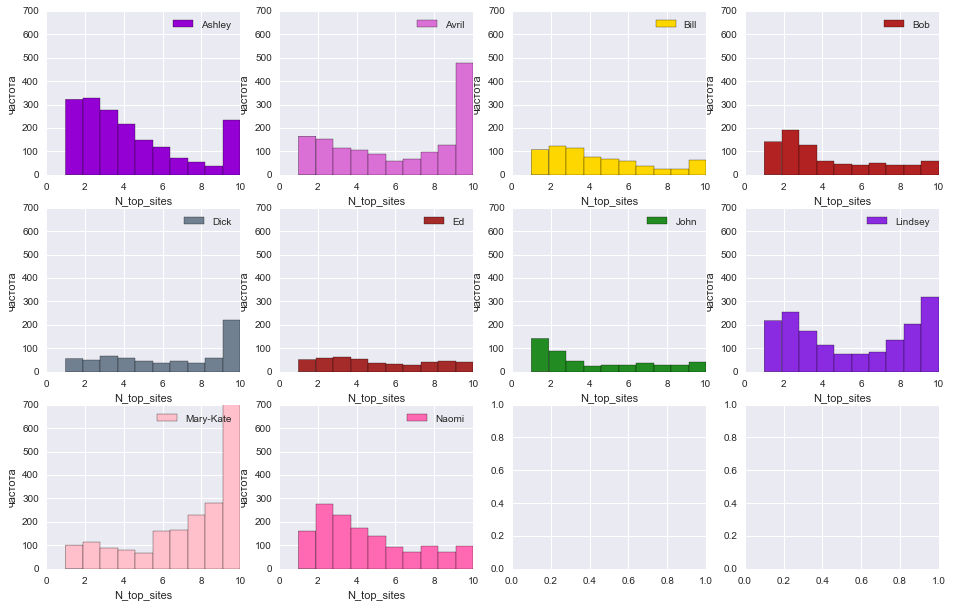

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
      
    axes[idx].hist(sub_df['N_top_site'][sub_df['N_top_site']>0] , color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'N_top_sites')
    axes[idx].axis([0, 10, 0, 700])
    #axes[idx].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    axes[idx].set_ylabel(u'частота')
    axes[idx].legend()

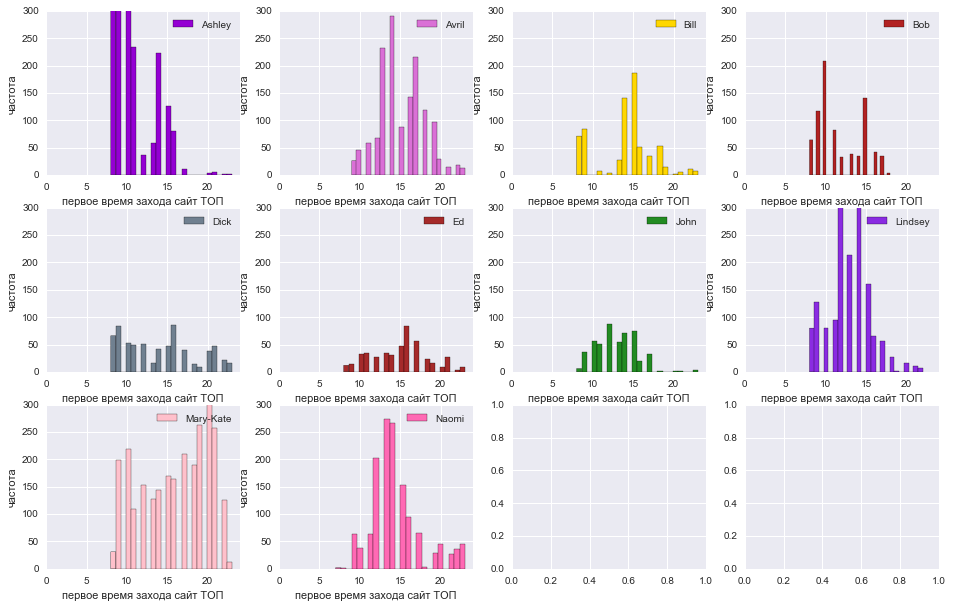

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    
    axes[idx].hist(sub_df['min_popular_time'][sub_df['min_popular_time']>0] ,bins =24, color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'первое время захода сайт ТОП')
    axes[idx].axis([0, 24, 0, 300])
    axes[idx].set_ylabel(u'частота')
    axes[idx].legend()

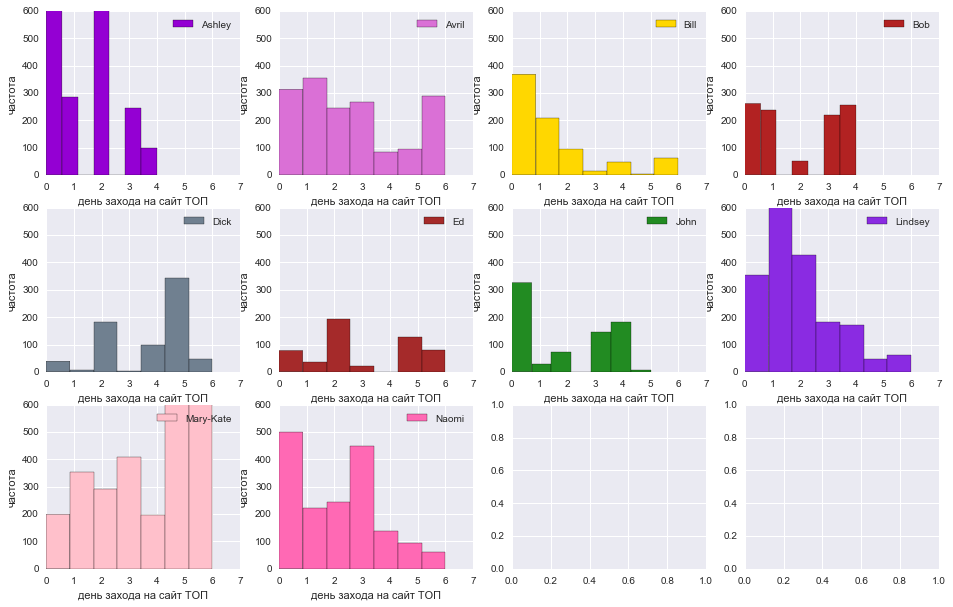

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    
    axes[idx].hist(sub_df['day_popular_time'] ,bins =7, color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'день захода на сайт ТОП')
    axes[idx].axis([0, 7, 0, 600])
    axes[idx].set_ylabel(u'частота')
    axes[idx].legend()

- построим гистограмму максимального времени проведенного на сайте из ТОП_30 в логарифмической шкале

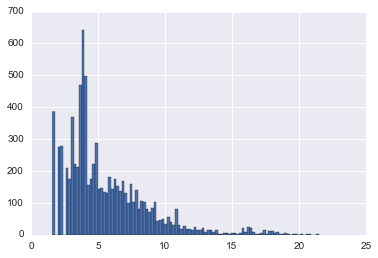

In [50]:
plt.hist(np.log2(new_features_10users['max_popular_diff'][new_features_10users['max_popular_diff']>2]), bins = 100)
plt.show()

- построим гистограмму максимального времени проведенного на сайте из ТОП_30 в логарифмической шкале для каждого пользователя

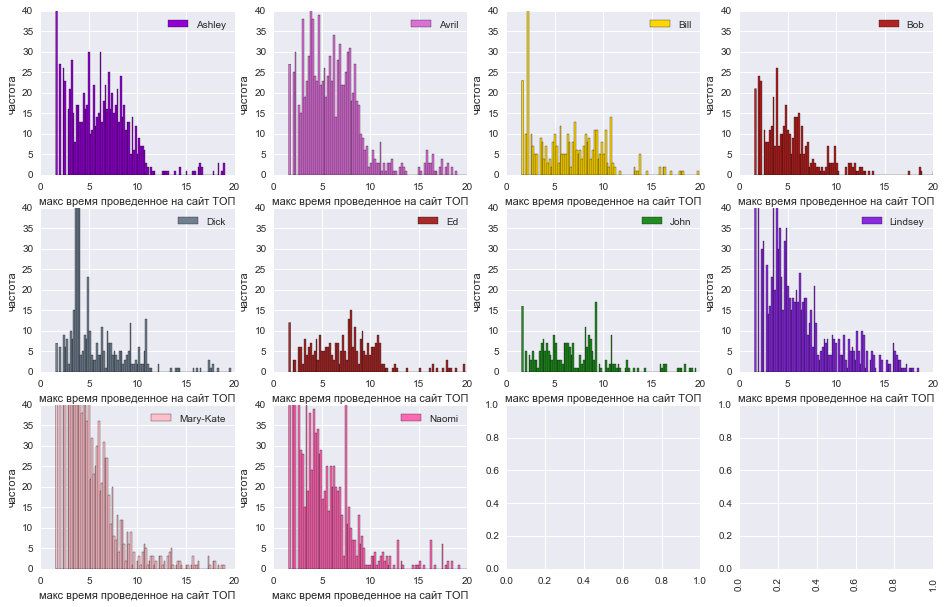

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.xticks(rotation=90)
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    data = np.log2(sub_df['max_popular_diff'][sub_df['max_popular_diff']>2])
    axes[idx].hist( data, bins =100, color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'макс время проведенное на сайт ТОП')
    axes[idx].axis([0, 20, 0, 40])
    
    axes[idx].set_ylabel(u'частота')
    axes[idx].legend()

- построим гистограмму среднего времени проведенного на сайте из ТОП_30 в логарифмической шкале для каждого пользователя

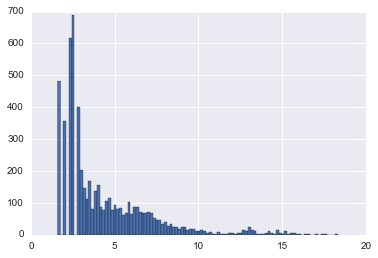

In [52]:
plt.hist(np.log2(new_features_10users['mean_popular_diff'][new_features_10users['mean_popular_diff']>2]), bins = 100)
plt.show()

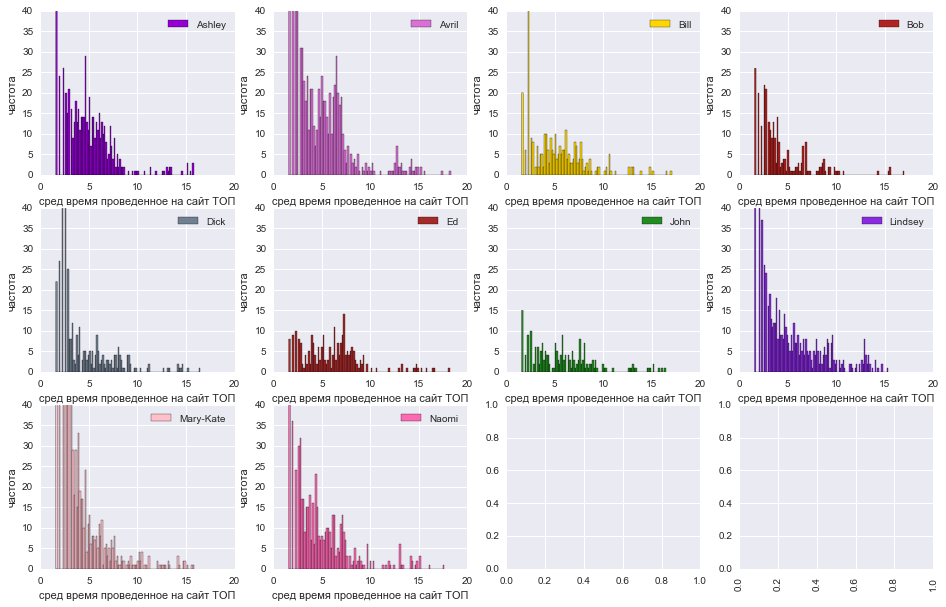

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.xticks(rotation=90)
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    data = np.log2(sub_df['mean_popular_diff'][sub_df['mean_popular_diff']>2])
    axes[idx].hist( data, bins =100, color = color_dic[user], label = user)
    
    axes[idx].set_xlabel(u'сред время проведенное на сайт ТОП')
    axes[idx].axis([0, 20, 0, 40])
    
    axes[idx].set_ylabel(u'частота')
    axes[idx].legend()

In [54]:
feature_names

['N_top_site',
 'min_popular_time',
 'day_popular_time',
 'mean_popular_diff',
 'max_popular_diff',
 'target']

- проанализировав картинки можно сделать вывод что все признаки а именно: 'N_top_site', 'min_popular_time', 'day_popular_time',  'mean_popular_diff', 'max_popular_diff', 'target' можно использовать 
- еще я бы добавил N_gramm для начала из двух сайтов подряд чтобы посмотреть какие сайты чаще всего идут друг за другом но надо остерегаться "проклятия размерности"

**В конце сохраним в pickle-файлы только те признаки, которые, помогут идентифицировать пользователя более точно. Это касается и признаков, которые  созданы в начале (*session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [55]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,4,5,6,7,8,7,273,3,28,916,-1523,10,0,0,1,1523,8,8,4,John
1,7,8,7,7,9,10,11,12,13,14,1,0,1,0,0,1,0,163,105,271,8,8,4,John
2,7,15,16,17,17,8,17,17,10,3,4,3,8,1,0,14,1,242,0,273,7,8,4,John
3,18,19,20,17,21,17,17,17,17,22,1,0,0,2,1,1,25,1,0,31,6,8,4,John
4,23,24,25,17,26,27,28,29,30,31,0,0,1,1,1,1,0,1,1,6,10,8,4,John


In [56]:
feature_names_select1 = ['time_diff' + str(j) for j in range(1,10)] + \
                ['#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_10users[feature_names_select1].head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,#unique_sites,start_hour,day_of_week,target
0,273,3,28,916,-1523,10,0,0,1,8,8,4,John
1,1,0,1,0,0,1,0,163,105,8,8,4,John
2,4,3,8,1,0,14,1,242,0,7,8,4,John
3,1,0,0,2,1,1,25,1,0,6,8,4,John
4,0,0,1,1,1,1,0,1,1,10,8,4,John


In [60]:
train_data_10users[feature_names[:-1]] = new_features_10users[feature_names[:-1]]
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,N_top_site,min_popular_time,day_popular_time,mean_popular_diff,max_popular_diff
0,1,2,2,3,4,5,6,7,8,7,273,3,...,0,1,1523,8,8,4,John,2,8,4,101,916
1,7,8,7,7,9,10,11,12,13,14,1,0,...,163,105,271,8,8,4,John,1,8,4,0,0
2,7,15,16,17,17,8,17,17,10,3,4,3,...,242,0,273,7,8,4,John,2,8,4,1,14
3,18,19,20,17,21,17,17,17,17,22,1,0,...,1,0,31,6,8,4,John,0,0,0,0,0
4,23,24,25,17,26,27,28,29,30,31,0,0,...,1,1,6,10,8,4,John,0,0,0,0,0


In [62]:
selected_features_10users = train_data_10users[feature_names_select1]
selected_features_10users.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,#unique_sites,start_hour,day_of_week,target
0,273,3,28,916,-1523,10,0,0,1,8,8,4,John
1,1,0,1,0,0,1,0,163,105,8,8,4,John
2,4,3,8,1,0,14,1,242,0,7,8,4,John
3,1,0,0,2,1,1,25,1,0,6,8,4,John
4,0,0,1,1,1,1,0,1,1,10,8,4,John


In [63]:
selected_features_10users[feature_names[:-1]] = new_features_10users[feature_names[:-1]]
selected_features_10users.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,#unique_sites,start_hour,day_of_week,target,N_top_site,min_popular_time,day_popular_time,mean_popular_diff,max_popular_diff
0,273,3,28,916,-1523,10,0,0,1,8,8,4,John,2,8,4,101,916
1,1,0,1,0,0,1,0,163,105,8,8,4,John,1,8,4,0,0
2,4,3,8,1,0,14,1,242,0,7,8,4,John,2,8,4,1,14
3,1,0,0,2,1,1,25,1,0,6,8,4,John,0,0,0,0,0
4,0,0,1,1,1,1,0,1,1,10,8,4,John,0,0,0,0,0


In [64]:
%%time
selected_features_150users = train_data_150users[feature_names_select1]
selected_features_150users.head()

Wall time: 39 ms


In [65]:
%time selected_features_150users[feature_names[:-1]] = new_features_150users[feature_names[:-1]]
selected_features_150users.head()

Wall time: 1.21 s


,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,#unique_sites,start_hour,day_of_week,target,N_top_site,min_popular_time,day_popular_time,mean_popular_diff,max_popular_diff
0,1,1,4,1,0,159,0,1504,4,6,8,4,6,2,8,4,0,4
1,21,56,1921,18,1999,6,0,3,4,3,8,4,6,0,0,0,0,0
2,0,1,0,1,0,1,0,0,0,5,9,4,6,2,9,4,0,0
3,0,0,0,1,0,0,0,0,0,6,9,4,6,2,9,4,0,0
4,0,0,0,0,0,1,0,0,0,6,9,4,6,2,9,4,0,0


In [66]:
# selected features – among (session_timespan, ..., day_of_week) and your own new ones
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящая [статья](https://habrahabr.ru/post/308162/) по этому ремеслу)
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями, не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши
.